In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler



%matplotlib inline



It is clear that several of the features contain outliers.
These are skewing the histograms and they can negatively affect our regressors


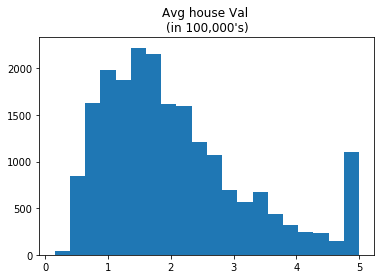

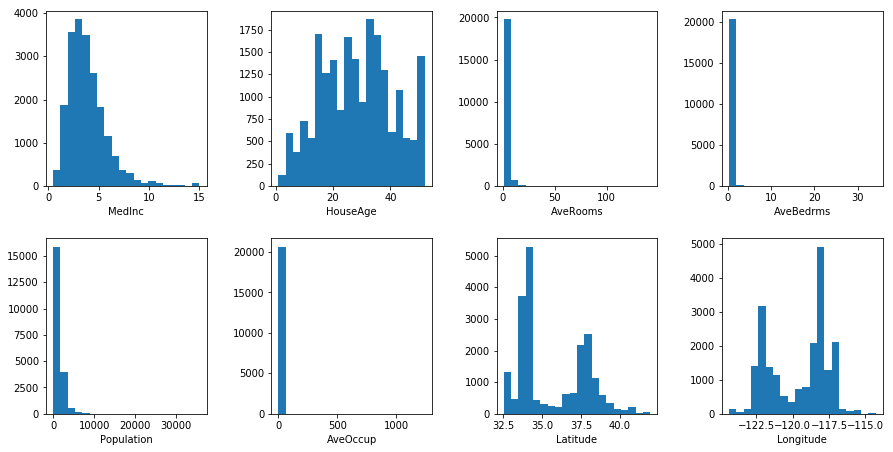

In [2]:
# TASK 1.1
ds = datasets.fetch_california_housing()

plt.hist(ds.target, bins=20)
plt.title("Avg house Val \n(in 100,000's)")

fig, axs = plt.subplots(2,4)
fig.set_size_inches(15, 8)
plt.subplots_adjust(top = 0.90, bottom=0.2, hspace=0.3, wspace=0.4)

counter = 0
for i in range(0,2):
    for j in range(0,4):
        axs[i,j].hist(ds.data[:,counter], bins=20)
        axs[i,j].set_xlabel(ds.feature_names[counter])
        counter+=1

print("\n\nIt is clear that several of the features contain outliers.\n " 
      + "These are skewing the histograms and they can negatively affect our regressors")


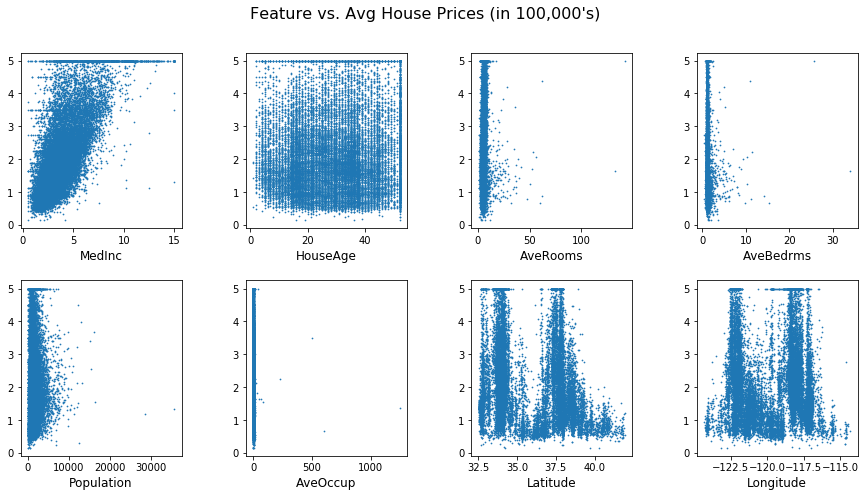

In [3]:
# TASK 1.2

counter=0
fig, axs = plt.subplots(2,4)
fig.suptitle("Feature vs. Avg House Prices (in 100,000's)", fontsize=16)
fig.set_size_inches(15, 8)
plt.subplots_adjust(top = 0.90, bottom=0.2, hspace=0.3, wspace=0.4)

for i in range(0,2):
    for j in range(0,4):
        axs[i,j].scatter(ds.data[:,counter], ds.target, s=.5)
        axs[i,j].set_xlabel(ds.feature_names[counter], fontsize=12)
        counter+=1

In [19]:
# TASK 1.3

X_train, X_test, y_train, y_test = train_test_split(
ds.data, ds.target, test_size=0.2, random_state=0)

scores = []

scores.append(np.average(cross_val_score(linear_model.LinearRegression(), X_train, y_train, cv=5)))

scores.append(np.average(cross_val_score(linear_model.Ridge(), X_train, y_train, cv=5)))

scores.append(np.average(cross_val_score(linear_model.Lasso(), X_train, y_train, cv=5)))

scores.append(np.average(cross_val_score(linear_model.ElasticNet(), X_train, y_train, cv=5)))


# repeating steps above using StandardScaler
scores_scaled = []

scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = scaler.transform(X_train)

reg = linear_model.LinearRegression()
scores_scaled.append(np.average(cross_val_score(reg, X_train_scaled, y_train, cv=5)))
ols = reg.fit(X_train_scaled, y_train)

reg = linear_model.Ridge()
scores_scaled.append(np.average(cross_val_score(reg, X_train_scaled, y_train, cv=5)))
ridge_def = reg.fit(X_train_scaled, y_train)

reg = linear_model.Lasso()
scores_scaled.append(np.average(cross_val_score(reg, X_train_scaled, y_train, cv=5)))
lasso_def = reg.fit(X_train_scaled, y_train)

reg = linear_model.ElasticNet()
scores_scaled.append(np.average(cross_val_score(reg, X_train_scaled, y_train, cv=5)))
enet_def = reg.fit(X_train_scaled, y_train)
    
    
print("{:10s} | {:10s} | {:10s} | {:10s} | {:10s}".format("Scaled", "OLS", "Ridge", "Lasso", "Elastic Net"))
print(''.join(['-'] * 65))
print("{:10s}   {:^10.3f}   {:^10.3f}   {:^10.3f}   {:^10.3f}".format(*list(["No"] + scores)))
print("{:10s}   {:^10.3f}   {:^10.3f}   {:^10.3f}   {:^10.3f}".format(*list(["Yes"] + scores_scaled)))

print("\nLasso and Elastic Net performed much worse on scaled data," +
      "\nbut this may be because default hyperparameters for these" + 
      "\nmodels are not corret. Ridge regression performed the same.")

Scaled     | OLS        | Ridge      | Lasso      | Elastic Net
-----------------------------------------------------------------
No             0.605        0.605        0.294        0.430   
Yes            0.605        0.605        -0.000       0.210   

Lasso and Elastic Net performed much worse on scaled data,
but this may be because default hyperparameters for these
models are not corret. Ridge regression performed the same.


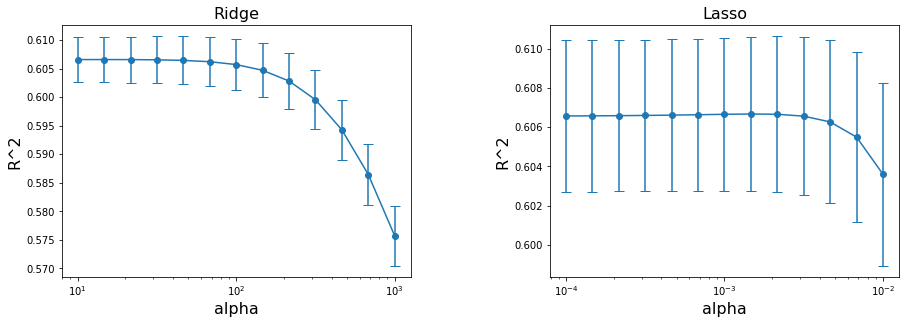

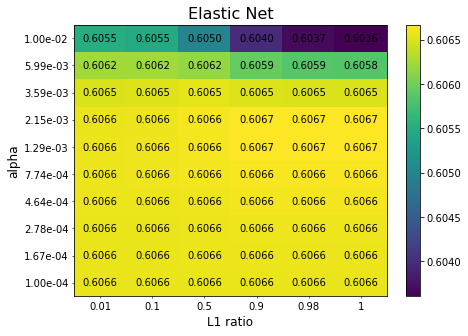



Regressor's performance on test set

Regressor       | with default params  | with GridSearchCV tuning
----------------------------------------------------------------------
Ridge           |        0.594         |        0.594         
Lasso           |        -0.000        |        0.594         
Elastic Net     |        0.201         |        0.594         


In [118]:
# TASK 1.4
res = []
test_scores = []
regressors = ["Ridge", "Lasso", "Elastic Net"]

# Ridge regression
reg_grid = GridSearchCV(linear_model.Ridge(), param_grid={'alpha': np.logspace(1, 3, 13)})
reg_grid.fit(X_train_scaled, y_train)
res.append(pd.DataFrame(reg_grid.cv_results_))
ridge_best = reg_grid.best_estimator_

# Lasso Regression
reg_grid = GridSearchCV(linear_model.Lasso(), param_grid={'alpha': np.logspace(-4, -2, 13)})
reg_grid.fit(X_train_scaled, y_train)
res.append(pd.DataFrame(reg_grid.cv_results_))
lasso_best = reg_grid.best_estimator_

# Elastic Net Regression
param_grid = {'alpha': np.logspace(-4, -2, 10),
              'l1_ratio': [0.01, .1, .5, .9, .98, 1]}

reg_grid = GridSearchCV(linear_model.ElasticNet(), param_grid)
reg_grid.fit(X_train_scaled, y_train)
res.append(pd.DataFrame(reg_grid.cv_results_))
enet_best = reg_grid.best_estimator_


# Visualize results
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plt.subplots_adjust(top = 0.90, bottom=0.2, hspace=0.3, wspace=0.4)

for i in range(0, 2):
    axs[i].set_xscale('log')
    axs[i].errorbar(res[i]['param_alpha'], res[i]['mean_test_score'], 
                   yerr=res[i]['std_test_score'], fmt='-o', capsize=5)
    axs[i].set_xlabel("alpha", fontsize=16)
    axs[i].set_ylabel("R^2", fontsize=16)
    axs[i].set_title(regressors[i], fontsize=16)


## Start Heat map code
mean_scores = np.array(res[-1].mean_test_score).reshape(10, 6)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,5)
heatmap = plt.pcolor(mean_scores, cmap='viridis')

for y in range(mean_scores.shape[0]):
    for x in range(mean_scores.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % mean_scores[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                )
        

# Customize minor tick labels
ax.set_yticklabels('')
ax.set_yticks([.5 + i for i in range(0,10)], minor=True)
ax.set_yticklabels(['{:2.2e}'.format(f) for f in param_grid["alpha"]], minor=True)

ax.set_xticklabels('')
ax.set_xticks([.5 + i for i in range(0,6)], minor=True)
ax.set_xticklabels(param_grid["l1_ratio"], minor=True)

ax.tick_params(length=.01)
ax.set_xlabel("L1 ratio", fontsize=12)
ax.set_ylabel("alpha", fontsize=12)
plt.colorbar(heatmap)
plt.title("Elastic Net", fontsize=16)

## END HEAT MAP


print('\n')
print('Regressor\'s performance on test set\n')
print("{:15s} | {:20s} | {}".format("Regressor", "with default params", "with GridSearchCV tuning"))
print(''.join(["-"] * 70))
print("{:15s} | {:^20.3f} | {:^20.3f} ".format("Ridge", ridge_def.score(X_test_scaled, y_test), ridge_best.score(X_test_scaled, y_test)))
print("{:15s} | {:^20.3f} | {:^20.3f} ".format("Lasso", lasso_def.score(X_test_scaled, y_test), lasso_best.score(X_test_scaled, y_test)))
print("{:15s} | {:^20.3f} | {:^20.3f} ".format("Elastic Net", enet_def.score(X_test_scaled, y_test), enet_best.score(X_test_scaled, y_test)))


In [7]:
#TASK 1.5

print("\nCoefficients of the different Regressors with tuned params\n")
print('{:9s} | {:6s} | {:8s} | {:8s} | {:8s} | {:6s} | {:8s} | {:8s} | {:8s}'.format("Regressor", "MedInc", "HouseAge", "AvgRooms", "AvgBeds", "Pop", "AvgOccup", "Latitude", "Longitud"))
print(''.join(['-'] * 92))
print('{:9s}   {:^6.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}   {:^4.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}'.format(*list(["OLS"] + ols.coef_.tolist())))
print('{:9s}   {:^6.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}   {:^4.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}'.format(*list(["Ridge"] + ridge_best.coef_.tolist())))
print('{:9s}   {:^6.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}   {:^4.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}'.format(*list(["Lasso"] + lasso_best.coef_.tolist())))
print('{:9s}   {:^6.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}   {:^4.3f}   {:^8.3f}   {:^8.3f}   {:^8.3f}'.format(*list(["E Net"] + enet_best.coef_.tolist())))


Coefficients of the different Regressors with tuned params

Regressor | MedInc | HouseAge | AvgRooms | AvgBeds  | Pop    | AvgOccup | Latitude | Longitud
--------------------------------------------------------------------------------------------
OLS         0.826     0.117      -0.249     0.290     -0.009    -0.031     -0.900     -0.871 
Ridge       0.826     0.118      -0.247     0.287     -0.008    -0.031     -0.889     -0.859 
Lasso       0.819     0.119      -0.228     0.270     -0.007    -0.030     -0.885     -0.854 
E Net       0.822     0.119      -0.237     0.278     -0.007    -0.030     -0.883     -0.853 
